In [7]:
import requests

# Dropbox link with `?dl=1` for direct download
url = "https://www.dropbox.com/scl/fi/3n0h6u7vffoicg0r62ccd/dog_and_cat_dataset.zip?rlkey=przipswldzvt0u30uplkuqa5f&st=5vkg3nmd&dl=1"


# Download the file
output_file = "dog_and_cat_dataset.zip"
response = requests.get(url)
if response.status_code == 200:
    with open(output_file, "wb") as file:
        file.write(response.content)
    print(f"Downloaded {output_file} successfully!")
else:
    print(f"Failed to download file: {response.status_code}")


Downloaded dog_and_cat_dataset.zip successfully!


In [8]:
import zipfile
import os

# Path to the downloaded ZIP file
zip_path = "dog_and_cat_dataset.zip"
extract_to = "dog_and_cat_dataset"  # Directory to extract files

# Extract the ZIP file
if zipfile.is_zipfile(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted files to {extract_to}")
else:
    print(f"{zip_path} is not a valid ZIP file")


Extracted files to dog_and_cat_dataset


In [9]:
for root, dirs, files in os.walk(extract_to):
    print(f"Directory: {root}")
    for file in files:
        print(f"  File: {file}")


Directory: dog_and_cat_dataset
Directory: dog_and_cat_dataset\dog_and_cat_dataset
Directory: dog_and_cat_dataset\dog_and_cat_dataset\test_set
Directory: dog_and_cat_dataset\dog_and_cat_dataset\test_set\cats
  File: cat.4001.jpg
  File: cat.4002.jpg
  File: cat.4003.jpg
  File: cat.4004.jpg
  File: cat.4005.jpg
  File: cat.4006.jpg
  File: cat.4007.jpg
  File: cat.4008.jpg
  File: cat.4009.jpg
  File: cat.4010.jpg
  File: cat.4011.jpg
  File: cat.4012.jpg
  File: cat.4013.jpg
  File: cat.4014.jpg
  File: cat.4015.jpg
  File: cat.4016.jpg
  File: cat.4017.jpg
  File: cat.4018.jpg
  File: cat.4019.jpg
  File: cat.4020.jpg
  File: cat.4021.jpg
  File: cat.4022.jpg
  File: cat.4023.jpg
  File: cat.4024.jpg
  File: cat.4025.jpg
  File: cat.4026.jpg
  File: cat.4027.jpg
  File: cat.4028.jpg
  File: cat.4029.jpg
  File: cat.4030.jpg
  File: cat.4031.jpg
  File: cat.4032.jpg
  File: cat.4033.jpg
  File: cat.4034.jpg
  File: cat.4035.jpg
  File: cat.4036.jpg
  File: cat.4037.jpg
  File: cat.4038

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from PIL import Image
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [11]:
# Defined paths

train_dir = 'dog_and_cat_dataset/dog_and_cat_dataset/training_set'
test_dir = 'dog_and_cat_dataset/dog_and_cat_dataset/test_set'


**__Exploratory Data Analysis__**

In [13]:
# Image data distribution

train_cats = glob(os.path.join(train_dir, 'cats', '*.jpg'))
train_dogs = glob(os.path.join(train_dir, 'dogs', '*.jpg'))
test_cats = glob(os.path.join(test_dir, 'cats', '*.jpg'))
test_dogs = glob(os.path.join(test_dir, 'dogs', '*.jpg'))

print(f'Number of training cat images: {len(train_cats)}')
print(f'Number of training dog images: {len(train_dogs)}')
print(f'Number of test cat images: {len(test_cats)}')
print(f'Number of test dog images: {len(test_dogs)}')

Number of training cat images: 4000
Number of training dog images: 4000
Number of test cat images: 1000
Number of test dog images: 1000


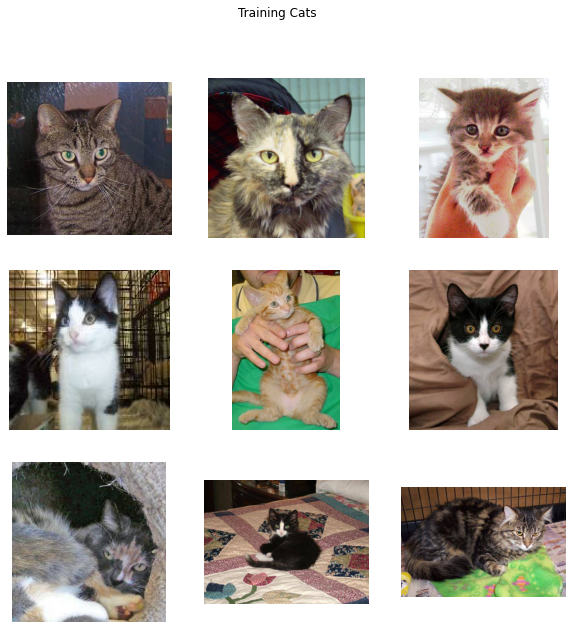

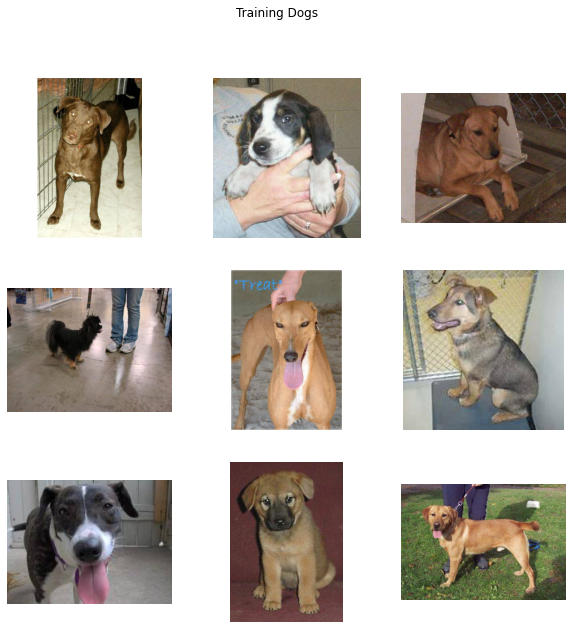

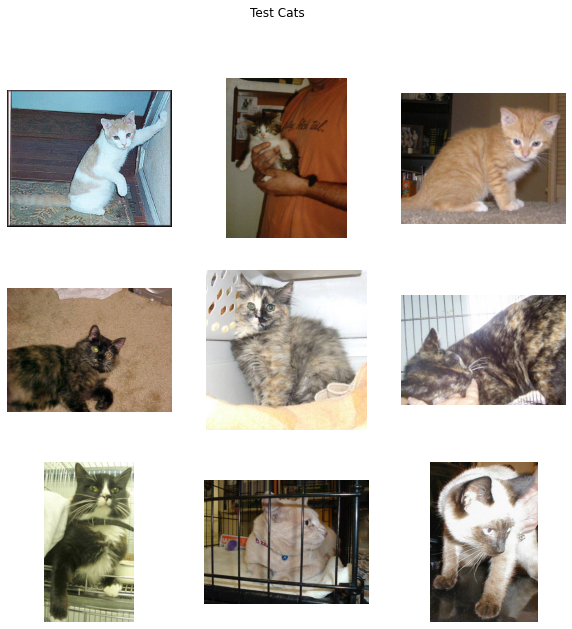

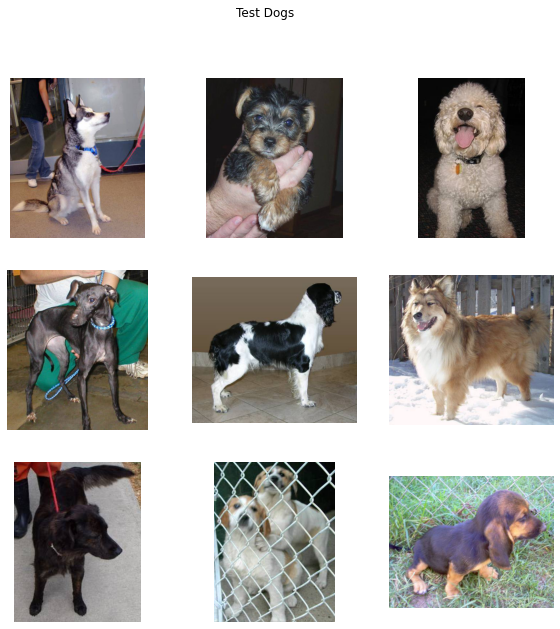

In [14]:
# Visualize some sample images from each category.

def plot_sample_images(images, title):
    plt.figure(figsize=(10, 10))
    for i, img_path in enumerate(images[:9]):
        plt.subplot(3, 3, i+1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_sample_images(train_cats, 'Training Cats')
plot_sample_images(train_dogs, 'Training Dogs')
plot_sample_images(test_cats, 'Test Cats')
plot_sample_images(test_dogs, 'Test Dogs')

Training Cats - Avg width: 409.61975, Avg height: 356.09925
Training Dogs - Avg width: 397.98225, Avg height: 364.84475


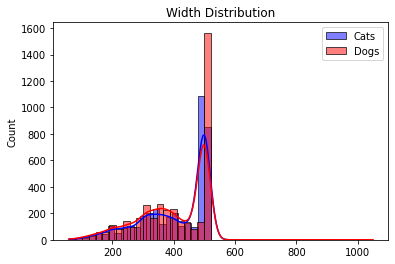

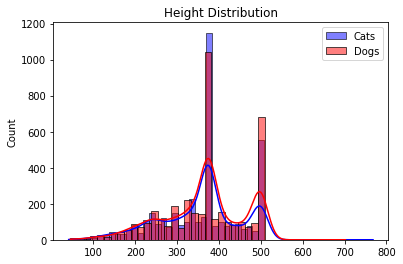

In [15]:
# Check the dimensions of images and some basic statistics.

def get_image_stats(images):
    widths, heights = [], []
    for img_path in images:
        img = Image.open(img_path)
        widths.append(img.width)
        heights.append(img.height)
    return widths, heights

train_cat_widths, train_cat_heights = get_image_stats(train_cats)
train_dog_widths, train_dog_heights = get_image_stats(train_dogs)

print(f'Training Cats - Avg width: {np.mean(train_cat_widths)}, Avg height: {np.mean(train_cat_heights)}')
print(f'Training Dogs - Avg width: {np.mean(train_dog_widths)}, Avg height: {np.mean(train_dog_heights)}')

# Plot distributions
sns.histplot(train_cat_widths, color='blue', label='Cats', kde=True)
sns.histplot(train_dog_widths, color='red', label='Dogs', kde=True)
plt.title('Width Distribution')
plt.legend()
plt.show()

sns.histplot(train_cat_heights, color='blue', label='Cats', kde=True)
sns.histplot(train_dog_heights, color='red', label='Dogs', kde=True)
plt.title('Height Distribution')
plt.legend()
plt.show()

In [16]:
# Validation set

# Create an instance of ImageDataGenerator with a validation split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Set as training data
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    train_dir,  # Note that this is still the training data
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Set as validation data
)

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


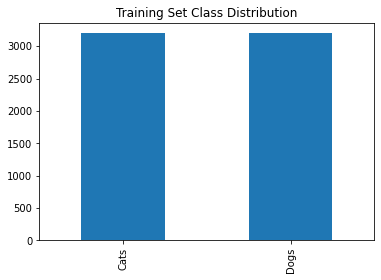

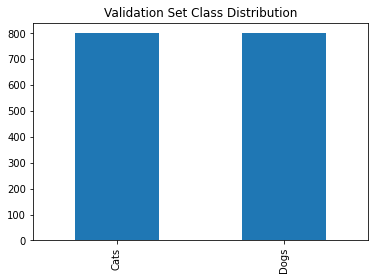

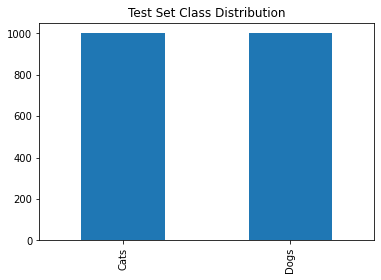

In [17]:
# Class Distribution

# Ensure that the classes (cats and dogs) are balanced in both training and test sets.

import pandas as pd

def class_distribution(generator, title):
    labels = generator.classes
    label_counts = pd.Series(labels).value_counts()
    label_counts.index = ['Cats', 'Dogs']
    label_counts.plot(kind='bar')
    plt.title(title)
    plt.show()

class_distribution(train_generator, 'Training Set Class Distribution')
class_distribution(validation_generator, 'Validation Set Class Distribution')
class_distribution(test_generator, 'Test Set Class Distribution')

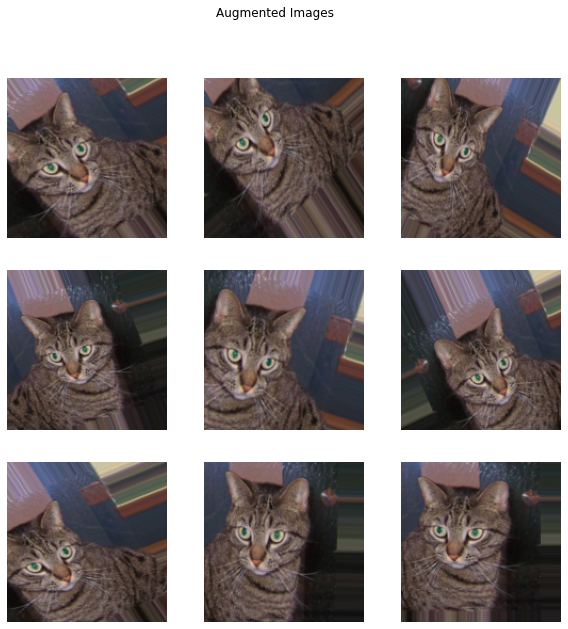

In [18]:
# Image Augmentation, Visual Inspection

# Check how the image augmentations look to ensure they make sense

# Define an augmentation configuration
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use a single image to visualize augmentations
img_path = train_cats[0]  # or any image path
img = Image.open(img_path)
img = img.resize((150, 150))
img = np.array(img).reshape((1, 150, 150, 3))

# Create an iterator
aug_iter = augmented_datagen.flow(img, batch_size=1)

# Plot augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    batch = aug_iter.next()
    aug_img = batch[0]
    plt.imshow(aug_img)
    plt.axis('off')
plt.suptitle('Augmented Images')
plt.show()

In [19]:
# Color Channel Statistics

# Checking the mean and standard deviation of pixel values across color channels (RGB)
# Analyzes pixel value statistics across color channels

def color_channel_stats(images):
    red_channel = []
    green_channel = []
    blue_channel = []
    for img_path in images:
        img = Image.open(img_path)
        img_array = np.array(img)
        red_channel.append(np.mean(img_array[:, :, 0]))
        green_channel.append(np.mean(img_array[:, :, 1]))
        blue_channel.append(np.mean(img_array[:, :, 2]))
    return np.mean(red_channel), np.std(red_channel), np.mean(green_channel), np.std(green_channel), np.mean(blue_channel), np.std(blue_channel)

train_cat_color_stats = color_channel_stats(train_cats)
train_dog_color_stats = color_channel_stats(train_dogs)

print(f'Training Cats - Red channel mean: {train_cat_color_stats[0]}, std: {train_cat_color_stats[1]}')
print(f'Training Cats - Green channel mean: {train_cat_color_stats[2]}, std: {train_cat_color_stats[3]}')
print(f'Training Cats - Blue channel mean: {train_cat_color_stats[4]}, std: {train_cat_color_stats[5]}')

print(f'Training Dogs - Red channel mean: {train_dog_color_stats[0]}, std: {train_dog_color_stats[1]}')
print(f'Training Dogs - Green channel mean: {train_dog_color_stats[2]}, std: {train_dog_color_stats[3]}')
print(f'Training Dogs - Blue channel mean: {train_dog_color_stats[4]}, std: {train_dog_color_stats[5]}')

Training Cats - Red channel mean: 123.59100141942343, std: 30.035866368994736
Training Cats - Green channel mean: 114.40431423953602, std: 28.48522222986961
Training Cats - Blue channel mean: 106.30515222176695, std: 29.127665506992127
Training Dogs - Red channel mean: 125.41958937881331, std: 28.601151976432117
Training Dogs - Green channel mean: 117.68592467133765, std: 27.42590246958416
Training Dogs - Blue channel mean: 106.56159913280374, std: 29.060690561963327


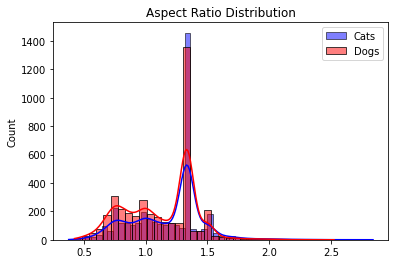

In [20]:
# Analyzing Image Aspect Ratios
# Checks for variation in aspect ratios

def get_aspect_ratios(images):
    aspect_ratios = []
    for img_path in images:
        img = Image.open(img_path)
        aspect_ratios.append(img.width / img.height)
    return aspect_ratios

train_cat_aspect_ratios = get_aspect_ratios(train_cats)
train_dog_aspect_ratios = get_aspect_ratios(train_dogs)

sns.histplot(train_cat_aspect_ratios, color='blue', label='Cats', kde=True)
sns.histplot(train_dog_aspect_ratios, color='red', label='Dogs', kde=True)
plt.title('Aspect Ratio Distribution')
plt.legend()
plt.show()

In [21]:
# Check if there are any corrupted images in the dataset.

def check_corrupted_images(images):
    corrupted_images = []
    for img_path in images:
        try:
            img = Image.open(img_path)
            img.verify()
        except (IOError, SyntaxError) as e:
            corrupted_images.append(img_path)
    return corrupted_images

corrupted_train_cats = check_corrupted_images(train_cats)
corrupted_train_dogs = check_corrupted_images(train_dogs)
corrupted_test_cats = check_corrupted_images(test_cats)
corrupted_test_dogs = check_corrupted_images(test_dogs)

print(f'Corrupted training cat images: {len(corrupted_train_cats)}')
print(f'Corrupted training dog images: {len(corrupted_train_dogs)}')
print(f'Corrupted test cat images: {len(corrupted_test_cats)}')
print(f'Corrupted test dog images: {len(corrupted_test_dogs)}')

Corrupted training cat images: 0
Corrupted training dog images: 0
Corrupted test cat images: 0
Corrupted test dog images: 0


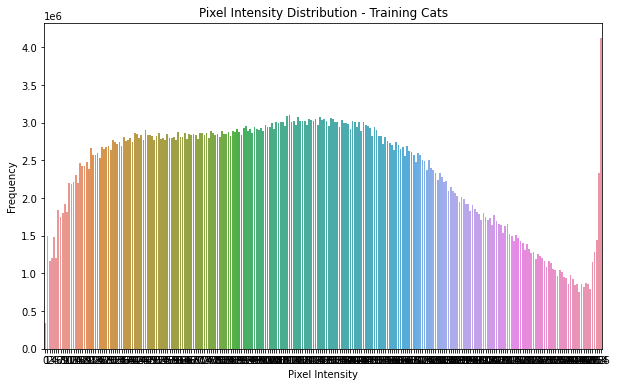

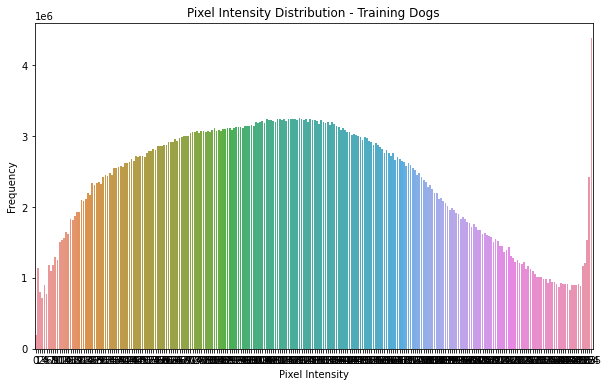

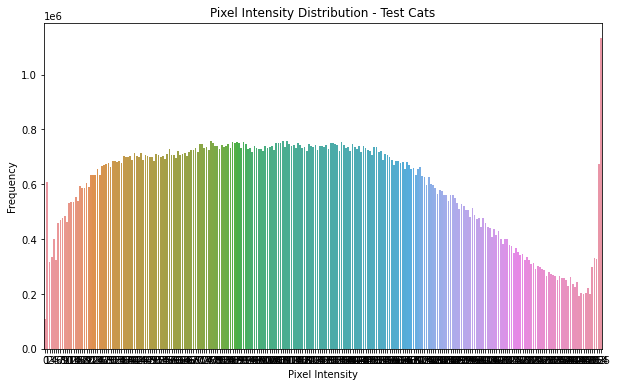

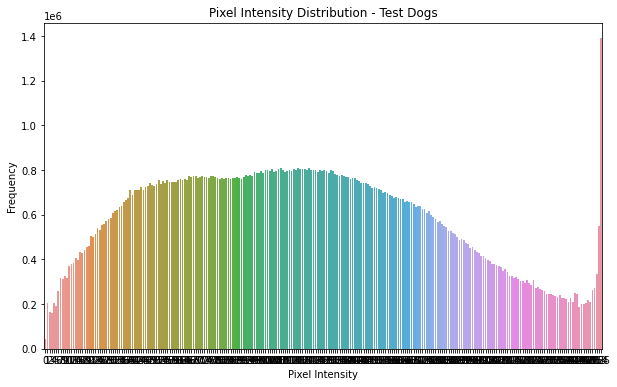

In [23]:
# Pixel Intensity Distribution
# Analyze the pixel intensity distribution to understand the brightness and contrast in images

def plot_pixel_intensity(images, title, batch_size=100):
    histogram = np.zeros(256)  # Since pixel intensities range from 0 to 255

    for i in range(0, len(images), batch_size):
        batch_images = images[i:i + batch_size]
        for img_path in batch_images:
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img_array = np.array(img).flatten()
            hist, _ = np.histogram(img_array, bins=256, range=(0, 256))
            histogram += hist

    plt.figure(figsize=(10, 6))
    sns.barplot(x=np.arange(256), y=histogram)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

# Assuming train_cats, train_dogs, test_cats, and test_dogs are defined
plot_pixel_intensity(train_cats, 'Pixel Intensity Distribution - Training Cats')
plot_pixel_intensity(train_dogs, 'Pixel Intensity Distribution - Training Dogs')
plot_pixel_intensity(test_cats, 'Pixel Intensity Distribution - Test Cats')
plot_pixel_intensity(test_dogs, 'Pixel Intensity Distribution - Test Dogs')

**__Data Preprocessing__**

In [27]:
# Data augmentation and rescaling for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% of training data used for validation
)

In [28]:
# Data augmentation and rescaling for test data
test_datagen = ImageDataGenerator(rescale=1./255)

In [31]:
# Train and validation generators
train_generator = train_datagen.flow_from_directory(
    'dog_and_cat_dataset/dog_and_cat_dataset/training_set',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'dog_and_cat_dataset/dog_and_cat_dataset/training_set',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    'dog_and_cat_dataset/dog_and_cat_dataset/test_set',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


**__Building and Training the Model__**

In [32]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Building the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [33]:
# Compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=25
)

Epoch 1/25
200/200 [==============================] - 329s 2s/step - loss: 0.6682 - accuracy: 0.5844 - val_loss: 0.6391 - val_accuracy: 0.6481
Epoch 2/25
200/200 [==============================] - 292s 1s/step - loss: 0.6109 - accuracy: 0.6662 - val_loss: 0.5572 - val_accuracy: 0.7181
Epoch 3/25
200/200 [==============================] - 257s 1s/step - loss: 0.5674 - accuracy: 0.7016 - val_loss: 0.5742 - val_accuracy: 0.6988
Epoch 4/25
200/200 [==============================] - 247s 1s/step - loss: 0.5361 - accuracy: 0.7317 - val_loss: 0.5048 - val_accuracy: 0.7462
Epoch 5/25
200/200 [==============================] - 782s 4s/step - loss: 0.5020 - accuracy: 0.7539 - val_loss: 0.5026 - val_accuracy: 0.7494
Epoch 6/25
200/200 [==============================] - 258s 1s/step - loss: 0.4818 - accuracy: 0.7725 - val_loss: 0.4601 - val_accuracy: 0.7713
Epoch 7/25
200/200 [==============================] - 253s 1s/step - loss: 0.4612 - accuracy: 0.7792 - val_loss: 0.4268 - val_accuracy: 0.7900